In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/gan_experiments'
os.chdir(path_basic)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid');

In [0]:
import pandas as pd
import numpy as np

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [0]:
def sit_to_dict(summary_iterators, tags, default_tag='G/GAN_A2B'):
  tag_values = defaultdict(list)

  for i in range(len(summary_iterators)):
    if i == len(summary_iterators) - 1:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      for tag in tags:
        event_tag = summary_iterators[i].Scalars(tag)
        values_now = [(e.step,e.value) for e in event_tag]
        tag_values[tag].extend(values_now)

      print(f"S-{i}: first:last step - {steps_now[0]}:{steps_now[-1]} - {len(steps_now)}")
    else:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      steps_next = [e.step for e in summary_iterators[i+1].Scalars(default_tag)]
      start = min(steps_now)
      stop = min(steps_next)
      if start - stop == 0:
        continue

      for tag in tags:
        event_tag = summary_iterators[i].Scalars(tag)
        values_now = [(e.step,e.value) for e in event_tag if e.step <= stop]
        tag_values[tag].extend(values_now)
      print(f"S-{i}: first:last step - {start}:{stop} - {len(steps_now)}")

    

  return tag_values

In [0]:
def get_sit(path):
  summary_iterators = [EventAccumulator(os.path.join(path, dname)).Reload() 
                    for dname in os.listdir(path)]
  summary_iterators = [s for s in summary_iterators if len(s.Tags()['scalars']) > 0]
  return summary_iterators


def get_csv(dict_object, tag):

  values = dict_object[tag]
  steps = [s[0] for s in values]
  values = [v[1] for v in values]

  df = pd.DataFrame(columns=['index', 'values'])
  df['index'] = steps
  df['values'] = values
  df = df.set_index('index')
  return df

In [0]:
def get_results_dict(path, stop_it):
  summary_iterator = get_sit(path)
  tags = summary_iterator[0].Tags()['scalars']
  tag_values = sit_to_dict(summary_iterator, tags)

  results = {}
  for tag in tags:
    df_values = get_csv(tag_values, tag)
    df_values = df_values[df_values.index < stop_it].copy()
    results[tag] = df_values.copy()

  return results

### Comparison 0.1.0 with 0.1.1 on 40k iterations


Preliminary:
  - More stable with lower std
  - Generators have significantly lower mean

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir='mask_shadow_gan/output/summary/summary_v0.1.0/2' --host localhost
# %tensorboard --logdir='mask_shadow_gan/output/summary/summary_v0.1.1/1'

In [0]:
PATH_010 = 'mask_shadow_gan/output/summary/summary_v0.1.0/2'
PATH_011 = 'mask_shadow_gan/output/summary/summary_v0.1.1/1'

In [9]:
summary_iterators_010 = get_sit(PATH_010)
summary_iterators_011 = get_sit(PATH_011)

In [0]:
m1 = max([max([ee.step for ee in e.Scalars('G/GAN_A2B')]) for e in summary_iterators_010])
m2 = max([max([ee.step for ee in e.Scalars('G/GAN_A2B')]) for e in summary_iterators_011])

In [11]:
STOP_IT = min(m1,m2)
print("V.0.1.0")
results_010 = get_results_dict(PATH_010, STOP_IT)

print("\nV.0.1.1")
results_011 = get_results_dict(PATH_011, STOP_IT)

V.0.1.0
S-0: first:last step - 10:41240 - 4514
S-1: first:last step - 41240:129020 - 8765
S-3: first:last step - 129020:175570 - 5066
S-4: first:last step - 175570:202170 - 3217
S-5: first:last step - 202170:222120 - 2292
S-6: first:last step - 222120:267330 - 4522

V.0.1.1
S-0: first:last step - 10:7990 - 1044
S-1: first:last step - 7990:21290 - 1830
S-2: first:last step - 21290:27940 - 1133
S-3: first:last step - 27940:34590 - 1196
S-4: first:last step - 34590:41240 - 1005
S-5: first:last step - 41240:44570 - 333
S-7: first:last step - 44570:44580 - 1
S-8: first:last step - 44580:53890 - 1581
S-9: first:last step - 53890:55220 - 163
S-10: first:last step - 55220:89800 - 3852
S-11: first:last step - 89800:90440 - 64
S-12: first:last step - 90440:94230 - 379
S-14: first:last step - 94230:109180 - 1495
S-15: first:last step - 109180:149080 - 4004
S-16: first:last step - 149080:163710 - 1473
S-17: first:last step - 163710:198290 - 3693
S-18: first:last step - 198290:212920 - 1679
S-19: f

In [0]:
tag_gab = 'G/GAN_A2B'
df_spec_gab_010 = results_010[tag_gab]
df_spec_gab_011 = results_011[tag_gab]

tag_db = 'D/D_B'
df_spec_db_010 = results_010[tag_db]
df_spec_db_011 = results_011[tag_db]

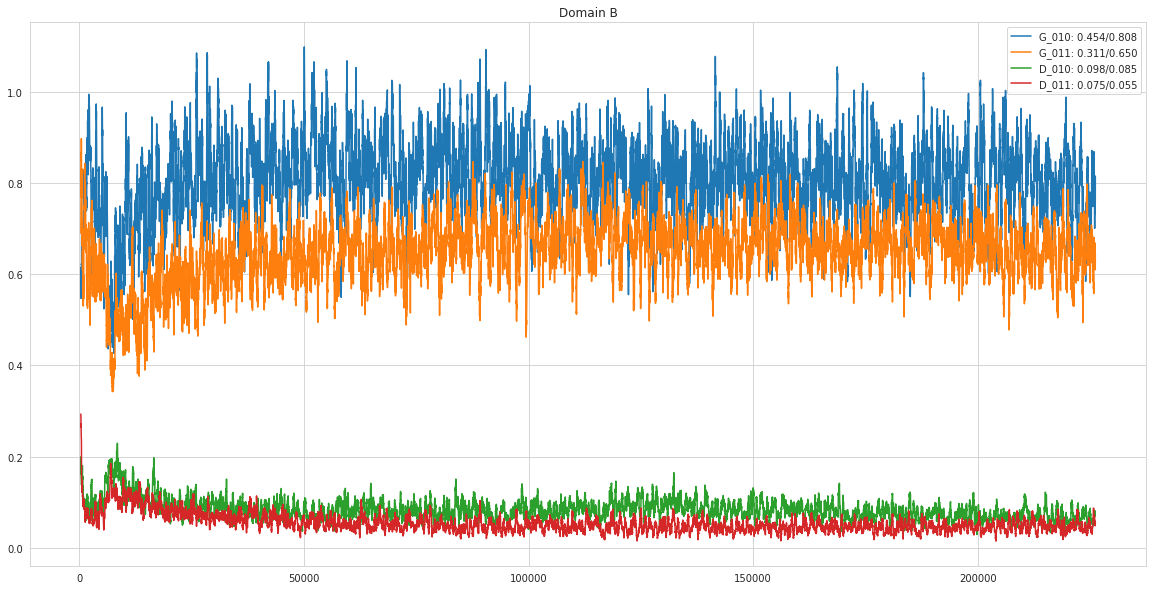

In [13]:
rm = 30
plt.subplots(figsize=(20,10))
plt.title("Domain B")
plt.plot(df_spec_gab_010.rolling(rm).mean(), 
         label=f'G_010: {df_spec_gab_010.std()[0]:.3f}/{df_spec_gab_010.mean()[0]:.3f}');
plt.plot(df_spec_gab_011.rolling(rm).mean(), 
         label=f'G_011: {df_spec_gab_011.std()[0]:.3f}/{df_spec_gab_011.mean()[0]:.3f}');

plt.plot(df_spec_db_010.rolling(rm).mean(), 
         label=f'D_010: {df_spec_db_010.std()[0]:.3f}/{df_spec_db_010.mean()[0]:.3f}');
plt.plot(df_spec_db_011.rolling(rm).mean(), 
         label=f'D_011: {df_spec_db_011.std()[0]:.3f}/{df_spec_db_011.mean()[0]:.3f}');
plt.legend();

In [0]:
tag_gba = 'G/GAN_B2A'
df_spec_gba_010 = results_010[tag_gba]
df_spec_gba_011 = results_011[tag_gba]

tag_da = 'D/D_A'
df_spec_da_010 = results_010[tag_da]
df_spec_da_011 = results_011[tag_da]

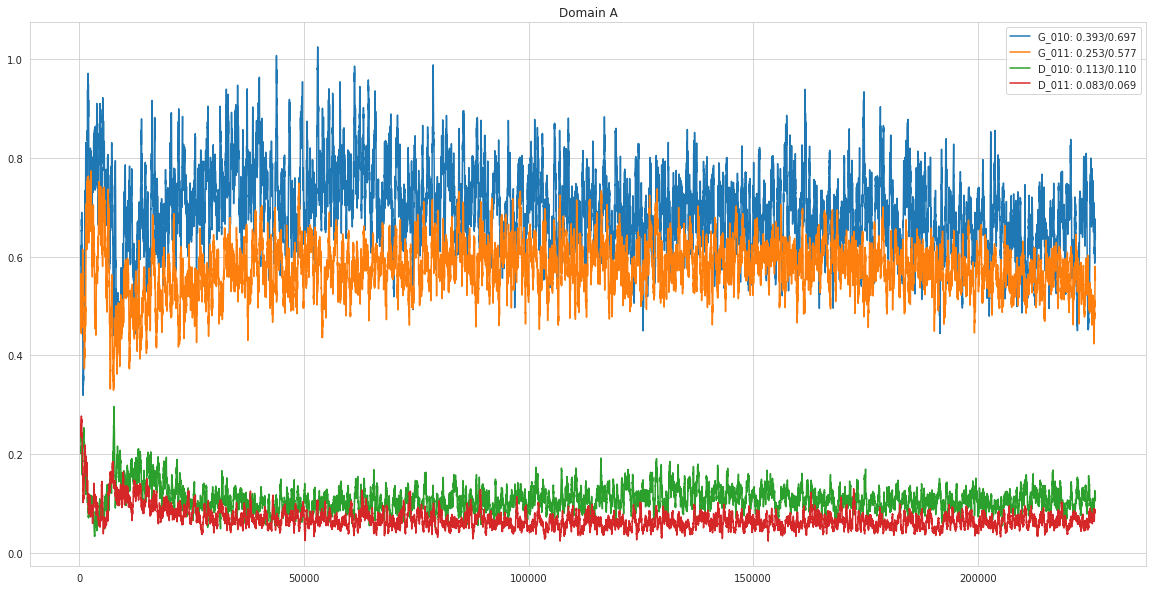

In [15]:
plt.subplots(figsize=(20,10))

plt.title("Domain A")
plt.plot(df_spec_gba_010.rolling(rm).mean(), 
         label=f'G_010: {df_spec_gba_010.std()[0]:.3f}/{df_spec_gba_010.mean()[0]:.3f}');
plt.plot(df_spec_gba_011.rolling(rm).mean(), 
         label=f'G_011: {df_spec_gba_011.std()[0]:.3f}/{df_spec_gba_011.mean()[0]:.3f}');

plt.plot(df_spec_da_010.rolling(rm).mean(), 
         label=f'D_010: {df_spec_da_010.std()[0]:.3f}/{df_spec_da_010.mean()[0]:.3f}');
plt.plot(df_spec_da_011.rolling(rm).mean(), 
         label=f'D_011: {df_spec_da_011.std()[0]:.3f}/{df_spec_da_011.mean()[0]:.3f}');

plt.legend();

In [0]:
tag_idtA = 'G/idt_A'
df_spec_idtA_010 = results_010[tag_idtA]
df_spec_idtA_011 = results_011[tag_idtA]

tag_idtB = 'G/idt_B'
df_spec_idtB_010 = results_010[tag_idtB]
df_spec_idtB_011 = results_011[tag_idtB]

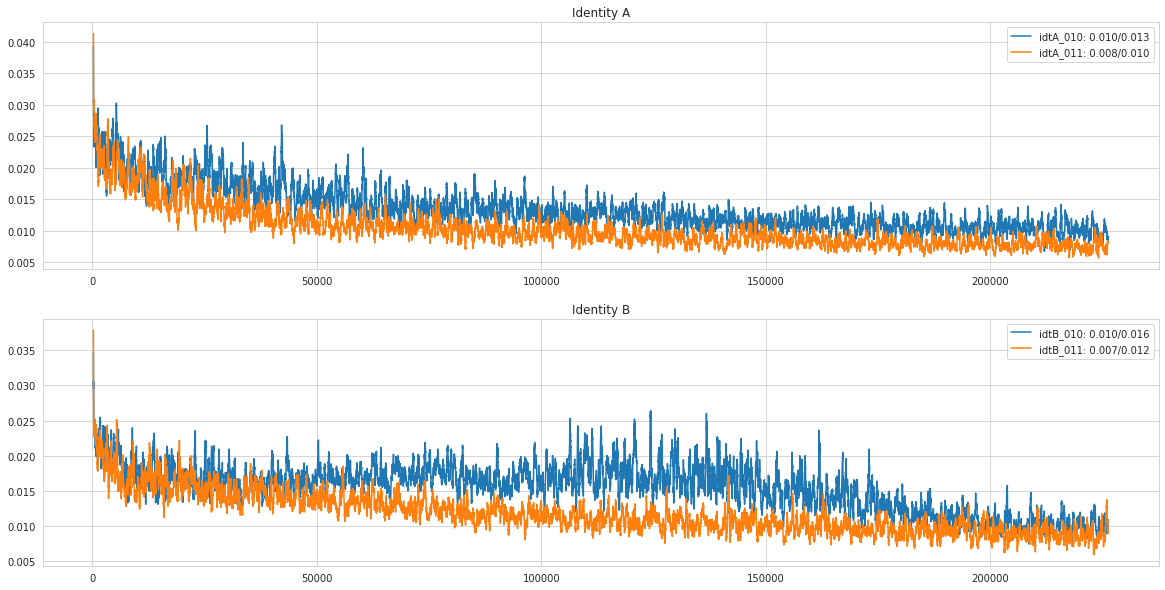

In [17]:
plt.subplots(figsize=(20,10))


plt.subplot(2,1,1)
plt.title("Identity A")
plt.plot(df_spec_idtA_010.rolling(rm).mean(), 
         label=f'idtA_010: {df_spec_idtA_010.std()[0]:.3f}/{df_spec_idtA_010.mean()[0]:.3f}');
plt.plot(df_spec_idtA_011.rolling(rm).mean(), 
         label=f'idtA_011: {df_spec_idtA_011.std()[0]:.3f}/{df_spec_idtA_011.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Identity B")
plt.plot(df_spec_idtB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_idtB_010.std()[0]:.3f}/{df_spec_idtB_010.mean()[0]:.3f}');
plt.plot(df_spec_idtB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_idtB_011.std()[0]:.3f}/{df_spec_idtB_011.mean()[0]:.3f}');

plt.legend();

In [0]:
tag_ABA = 'G/cycle_ABA'
df_spec_ABA_010 = results_010[tag_ABA]
df_spec_ABA_011 = results_011[tag_ABA]

tag_BAB = 'G/cycle_BAB'
df_spec_BAB_010 = results_010[tag_BAB]
df_spec_BAB_011 = results_011[tag_BAB]

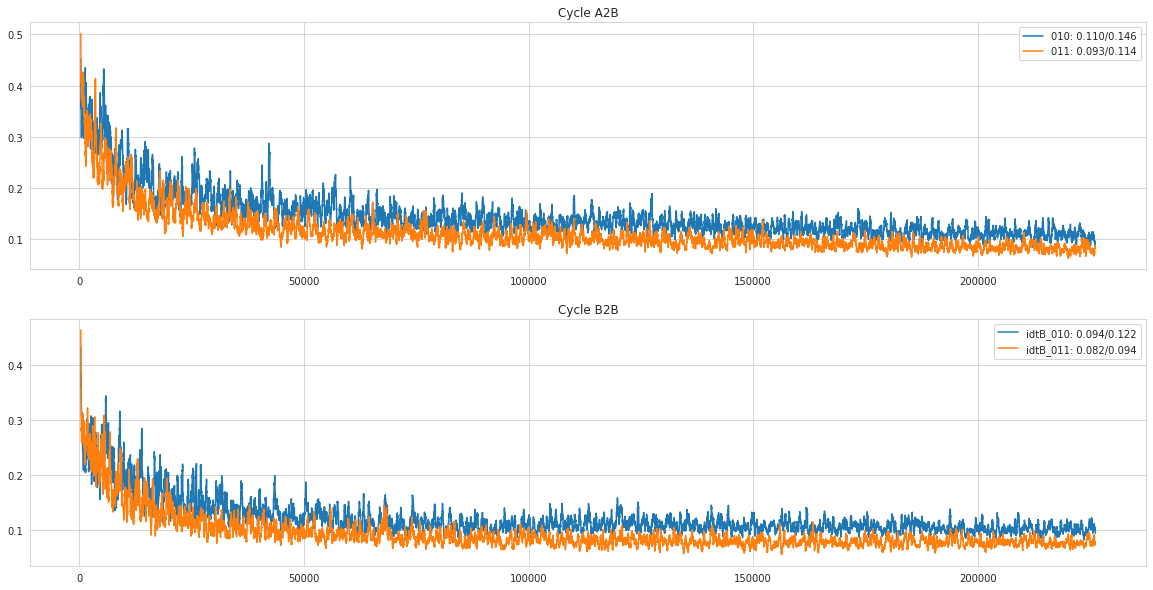

In [19]:
plt.subplots(figsize=(20,10))

plt.subplot(2,1,1)
plt.title("Cycle A2B")
plt.plot(df_spec_ABA_010.rolling(rm).mean(), 
         label=f'010: {df_spec_ABA_010.std()[0]:.3f}/{df_spec_ABA_010.mean()[0]:.3f}');
plt.plot(df_spec_ABA_011.rolling(rm).mean(), 
         label=f'011: {df_spec_ABA_011.std()[0]:.3f}/{df_spec_ABA_011.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Cycle B2B")
plt.plot(df_spec_BAB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_BAB_010.std()[0]:.3f}/{df_spec_BAB_010.mean()[0]:.3f}');
plt.plot(df_spec_BAB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_BAB_011.std()[0]:.3f}/{df_spec_BAB_011.mean()[0]:.3f}');

plt.legend();

### Comparison v0.1.1 with v0.1.2
Preliminary results (37k it):
  - Worse and less stable results

In [0]:
PATH_010 = 'mask_shadow_gan/output/summary/summary_v0.1.1/1'
PATH_011 = 'mask_shadow_gan/output/summary/summary_v0.1.2/1'

In [0]:
summary_iterators_010 = get_sit(PATH_010)
summary_iterators_011 = get_sit(PATH_011)

In [0]:
m1 = max([max([ee.step for ee in e.Scalars('G/GAN_A2B')]) for e in summary_iterators_010])
m2 = max([max([ee.step for ee in e.Scalars('G/GAN_A2B')]) for e in summary_iterators_011])

In [0]:
STOP_IT = min(m1,m2)
print("V.0.1.0")
results_010 = get_results_dict(PATH_010, STOP_IT)

print("\nV.0.1.1")
results_011 = get_results_dict(PATH_011, STOP_IT)

V.0.1.0
S-0: first:last step - 10:7990 - 1044
S-1: first:last step - 7990:21290 - 1830
S-2: first:last step - 21290:27940 - 1133
S-3: first:last step - 27940:34590 - 1196
S-4: first:last step - 34590:41240 - 1005
S-5: first:last step - 41240:44570 - 333
S-7: first:last step - 44570:44580 - 1
S-8: first:last step - 44580:53890 - 1581
S-9: first:last step - 53890:55220 - 163
S-10: first:last step - 55220:89800 - 3852
S-11: first:last step - 89800:90440 - 64
S-12: first:last step - 90440:94230 - 379
S-14: first:last step - 94230:109180 - 1495
S-15: first:last step - 109180:149080 - 4004
S-16: first:last step - 149080:163710 - 1473
S-17: first:last step - 163710:200630 - 3693

V.0.1.1
S-1: first:last step - 10:1340 - 264
S-2: first:last step - 1340:22620 - 2428
S-3: first:last step - 22620:37760 - 1514
S-4: first:last step - 37760:39090 - 171
S-5: first:last step - 39090:53720 - 1464


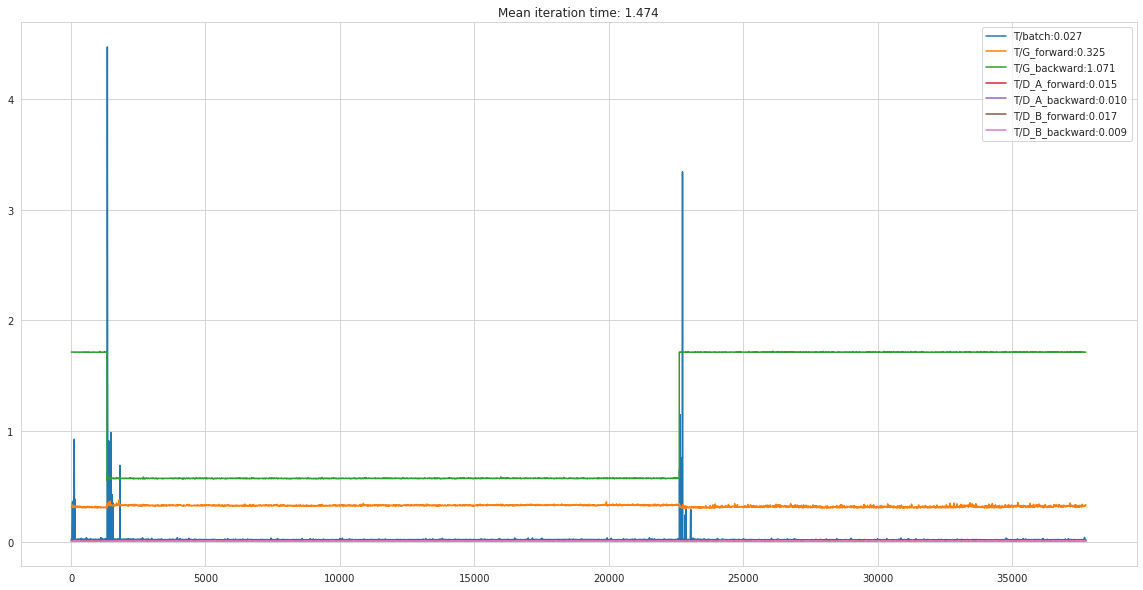

In [0]:
tags_time = [t for t in results_011.keys() if t.startswith('T')]
plt.subplots(figsize=(20,10))
suma = 0
n = results_011[tags_time[0]].shape[0]
for tag in tags_time:
  x = results_011[tag]
  suma += x.mean()
  plt.plot(x, label=f"{tag}:{x.mean()[0]:.3f}")

plt.title(f"Mean iteration time: {float(suma):.3f}")
plt.legend();

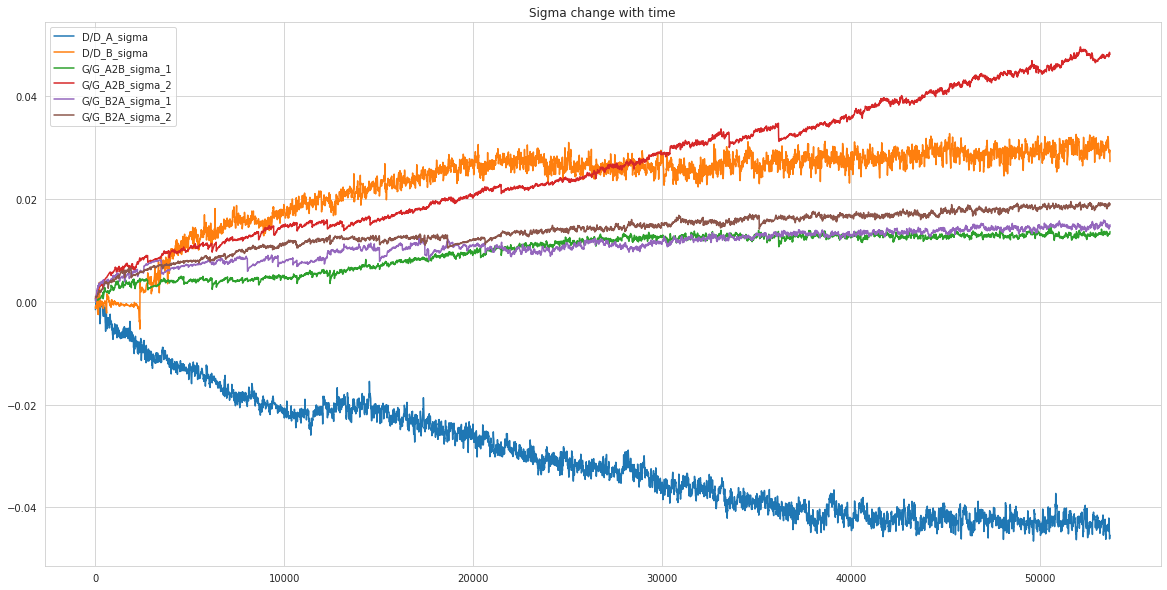

In [0]:
tags_sigma = [t for t in results_011.keys() if 'sigma' in t]
plt.subplots(figsize=(20,10))
for tag in tags_sigma:
  x = results_011[tag]
  plt.plot(x, label=f"{tag}")

plt.title(f"Sigma change with time")
plt.legend();

In [0]:
tag_gab = 'G/GAN_A2B'
df_spec_gab_010 = results_010[tag_gab]
df_spec_gab_011 = results_011[tag_gab]

tag_db = 'D/D_B'
df_spec_db_010 = results_010[tag_db]
df_spec_db_011 = results_011[tag_db]

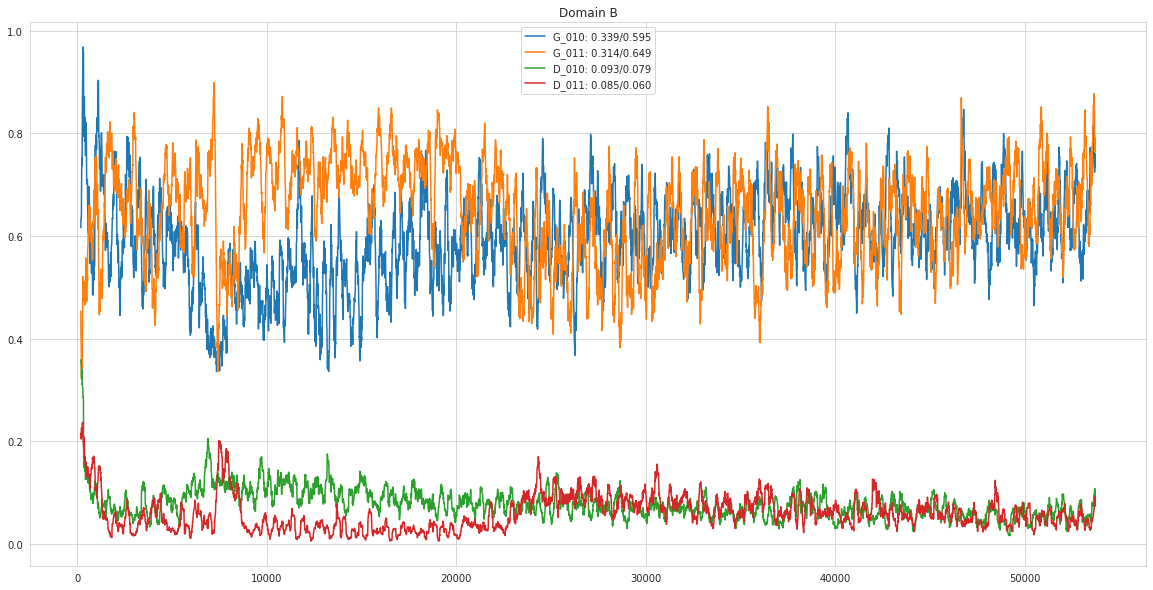

In [0]:
rm = 20
plt.subplots(figsize=(20,10))
plt.title("Domain B")
plt.plot(df_spec_gab_010.rolling(rm).mean(), 
         label=f'G_010: {df_spec_gab_010.std()[0]:.3f}/{df_spec_gab_010.mean()[0]:.3f}');
plt.plot(df_spec_gab_011.rolling(rm).mean(), 
         label=f'G_011: {df_spec_gab_011.std()[0]:.3f}/{df_spec_gab_011.mean()[0]:.3f}');

plt.plot(df_spec_db_010.rolling(rm).mean(), 
         label=f'D_010: {df_spec_db_010.std()[0]:.3f}/{df_spec_db_010.mean()[0]:.3f}');
plt.plot(df_spec_db_011.rolling(rm).mean(), 
         label=f'D_011: {df_spec_db_011.std()[0]:.3f}/{df_spec_db_011.mean()[0]:.3f}');
plt.legend();

In [0]:
tag_gba = 'G/GAN_B2A'
df_spec_gba_010 = results_010[tag_gba]
df_spec_gba_011 = results_011[tag_gba]

tag_da = 'D/D_A'
df_spec_da_010 = results_010[tag_da]
df_spec_da_011 = results_011[tag_da]

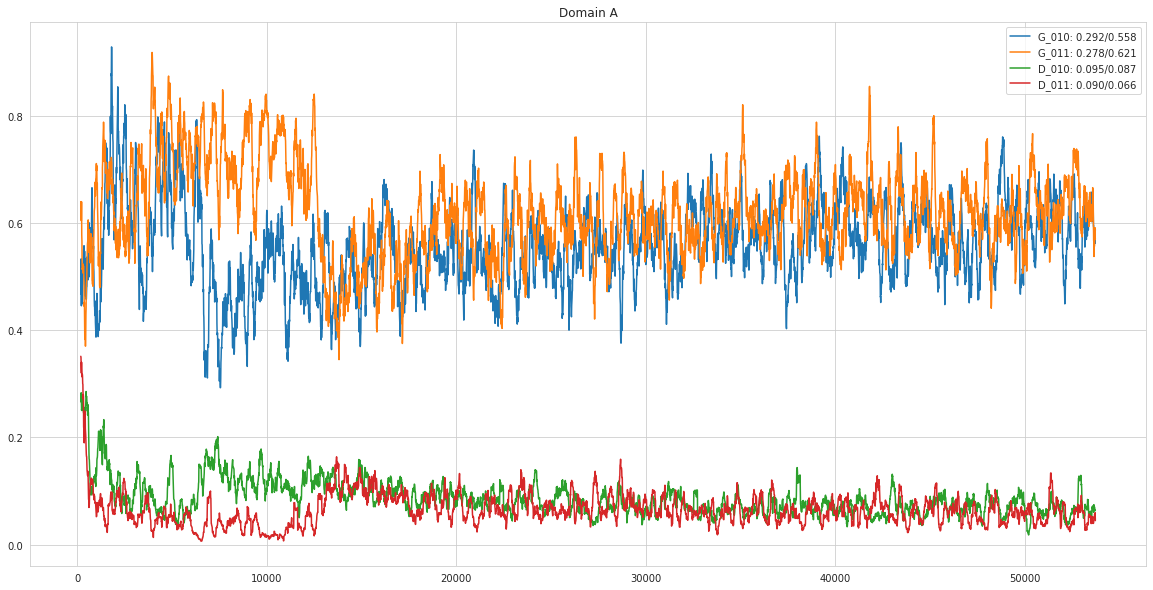

In [0]:

plt.subplots(figsize=(20,10))

plt.title("Domain A")
plt.plot(df_spec_gba_010.rolling(rm).mean(), 
         label=f'G_010: {df_spec_gba_010.std()[0]:.3f}/{df_spec_gba_010.mean()[0]:.3f}');
plt.plot(df_spec_gba_011.rolling(rm).mean(), 
         label=f'G_011: {df_spec_gba_011.std()[0]:.3f}/{df_spec_gba_011.mean()[0]:.3f}');

plt.plot(df_spec_da_010.rolling(rm).mean(), 
         label=f'D_010: {df_spec_da_010.std()[0]:.3f}/{df_spec_da_010.mean()[0]:.3f}');
plt.plot(df_spec_da_011.rolling(rm).mean(), 
         label=f'D_011: {df_spec_da_011.std()[0]:.3f}/{df_spec_da_011.mean()[0]:.3f}');

plt.legend();

In [0]:
tag_idtA = 'G/idt_A'
df_spec_idtA_010 = results_010[tag_idtA]
df_spec_idtA_011 = results_011[tag_idtA]

tag_idtB = 'G/idt_B'
df_spec_idtB_010 = results_010[tag_idtB]
df_spec_idtB_011 = results_011[tag_idtB]

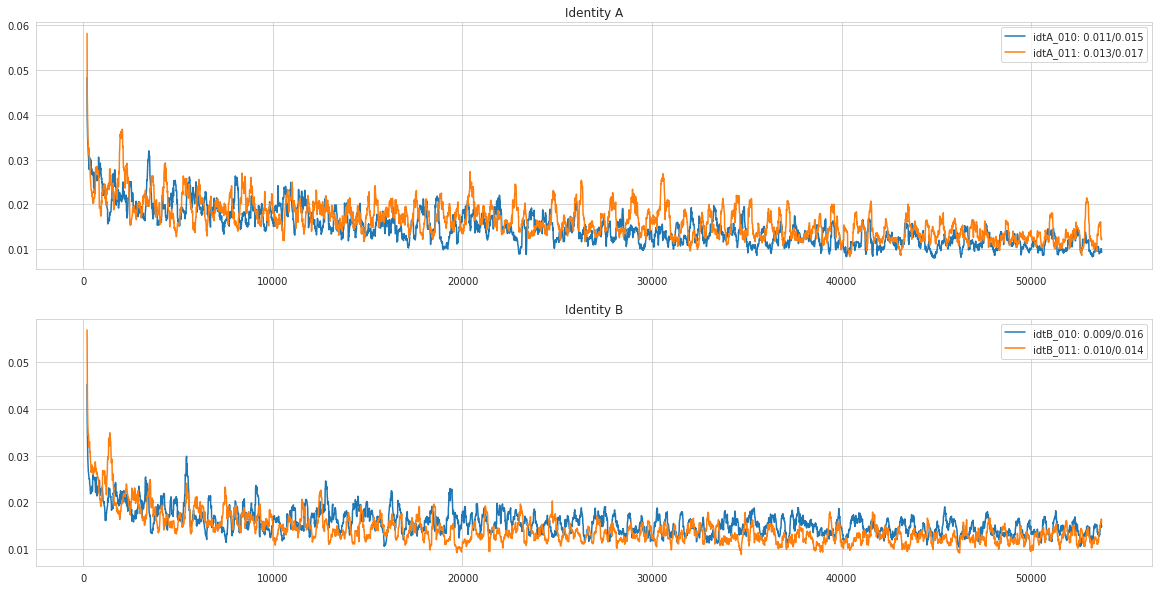

In [0]:
plt.subplots(figsize=(20,10))


plt.subplot(2,1,1)
plt.title("Identity A")
plt.plot(df_spec_idtA_010.rolling(rm).mean(), 
         label=f'idtA_010: {df_spec_idtA_010.std()[0]:.3f}/{df_spec_idtA_010.mean()[0]:.3f}');
plt.plot(df_spec_idtA_011.rolling(rm).mean(), 
         label=f'idtA_011: {df_spec_idtA_011.std()[0]:.3f}/{df_spec_idtA_011.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Identity B")
plt.plot(df_spec_idtB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_idtB_010.std()[0]:.3f}/{df_spec_idtB_010.mean()[0]:.3f}');
plt.plot(df_spec_idtB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_idtB_011.std()[0]:.3f}/{df_spec_idtB_011.mean()[0]:.3f}');

plt.legend();

In [0]:
tag_ABA = 'G/cycle_ABA'
df_spec_ABA_010 = results_010[tag_ABA]
df_spec_ABA_011 = results_011[tag_ABA]

tag_BAB = 'G/cycle_BAB'
df_spec_BAB_010 = results_010[tag_BAB]
df_spec_BAB_011 = results_011[tag_BAB]

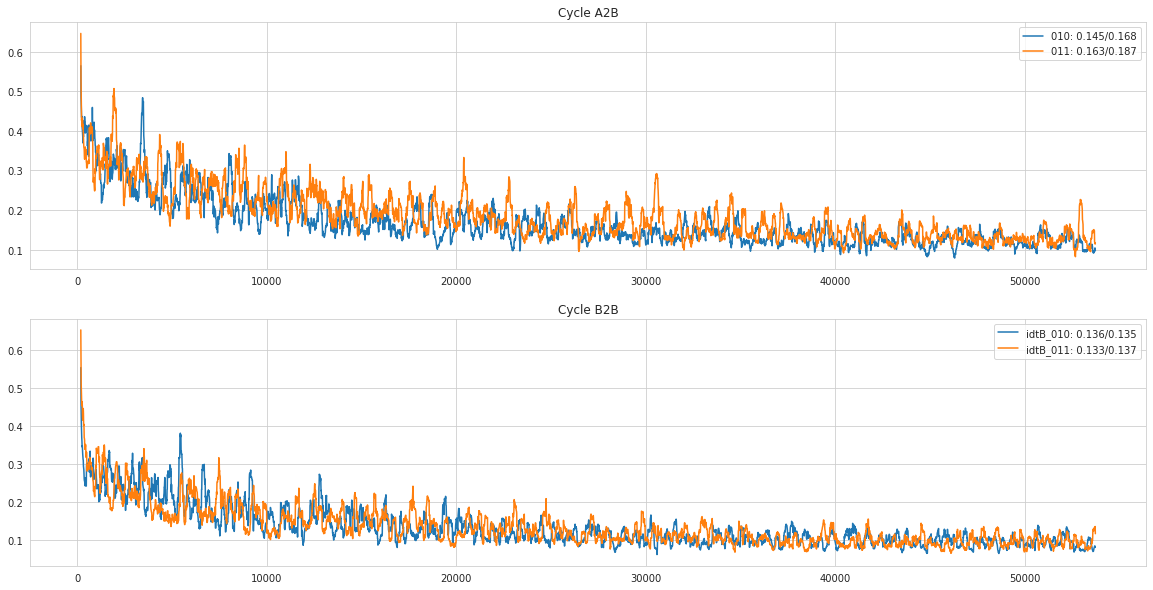

In [0]:
plt.subplots(figsize=(20,10))

plt.subplot(2,1,1)
plt.title("Cycle A2B")
plt.plot(df_spec_ABA_010.rolling(rm).mean(), 
         label=f'010: {df_spec_ABA_010.std()[0]:.3f}/{df_spec_ABA_010.mean()[0]:.3f}');
plt.plot(df_spec_ABA_011.rolling(rm).mean(), 
         label=f'011: {df_spec_ABA_011.std()[0]:.3f}/{df_spec_ABA_011.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Cycle B2B")
plt.plot(df_spec_BAB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_BAB_010.std()[0]:.3f}/{df_spec_BAB_010.mean()[0]:.3f}');
plt.plot(df_spec_BAB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_BAB_011.std()[0]:.3f}/{df_spec_BAB_011.mean()[0]:.3f}');

plt.legend();